## Day4概要および結論
- 前回、きのこデータをRandom Forestで分類した際、Score=1.0になりました。
- 今回、きのこデータをSVMで分類したところやはり容易にScore=1.0になりました。
- 
- データが簡単で分類しやすいためかと思いtrain_test_splitの比率を変え、訓練データを減らしたときの挙動を見ました。
- →　訓練データ数が1000個程度を下回るくらいから、Scoreが悪くなることがわかりました。
- →→　データ数は、もともと8000個程度あるので、十分な量があることがわかりました。
- →→　また、2値分類の問題（食べれるか否か）であって、かつ、説明変数が120個ほどある、
- →→　データに誤りや異常値がない(と思われる)ことから、やはり比較的分類しやすいデータなのかなと思いました。
- 
- またRandom Forestのfeature_importanceが高い説明変数、低い説明変数を使ったときの挙動を見ました。
- →　高いほうのみ20個の説明変数を使った場合は、最大Score=1.00、
- →　高いほうのみ10個の説明変数を使った場合は、最大Score=0.98程度、
- →　低いほうのみ10個の説明変数を使った場合は、最大Score=0.6 程度、となりました。
- →　importanceが、分類精度に寄与していることががわかりました。
- →　説明変数を減らしても高い汎化性能がでるのであれば、人間にとっての理解性が高いのでがよいと思いました。（説明変数の選択はなんらか機械的に選択したいところ）
- →　説明変数を117個すべて使うと、Score=1.0となりますがマルチコの影響が出ていないように見え、解析まで至っていません。
- 
- SVM linear, SVM rbf, Random Forest, Logistic Regressionの４つを使ったときの違いを見ました。
- →　高いほうのみ5個の説明変数を使った場合に、
- →　SVM linear：0.995以上、 
- →　SVM rbf、Random Forest、Logistic Regression：0.965程度
- →　と、若干の差(0.03ほど)がでました。(計算する毎にぶれますが。。。)理由として以下２点があると考えています。
- →　①SVMのマージン最大化のおかげ、②きのこデータが線形分離可能な可能性がありrbfは適さない。




In [1]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split , GridSearchCV # Data分割, Parameter tuning,
from IPython.display import display

In [2]:
# データ取り込み
dfm = pd.read_csv("mushrooms/mushrooms.csv")
#　きのこの属性表示。目的変数：class edible or poisonous 2値, 説明変数：22種。
print(dfm.columns)
print("shape:"+ str(dfm.shape))
#dfm.tail()

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')
shape:(8124, 23)


In [3]:
#  すべてカテゴリ変数なので、ダミー変数にする
dfm_d = pd.get_dummies(dfm)
dfm.shape

(8124, 23)

## 訓練データ数を変える

In [4]:
# train data, test dataを作る。
y = dfm_d.class_p.to_frame()
X = dfm_d.drop(["class_p","class_e"], axis=1)

## test_train_split用変数
test_size_list = [0.2,0.5,0.9,0.93,0.96,0.98,0.99,0.999]
test_split_num = 1 # ひとまず１回にする。複数回計算しその平均を取る予定だったが未実装。

## 解析用保存パラメータリスト
tmp_columns = ["test_spulit_num","test_size","train_score","test_score","X_train.shape","X_test.shape","X_train.shape[0]"]

### SVC Linear, SVC rbf, RandmForest, LogisticRegression、による計算をする。

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 

# 解析用パラメータ保存データフレーム
svm_liner_scores_for_each_size  = pd.DataFrame(index=[],columns=tmp_columns)
svm_rbf_scores_for_each_size    = pd.DataFrame(index=[],columns=tmp_columns)
randam_fo_scores_for_each_size  = pd.DataFrame(index=[],columns=tmp_columns)
logistic_r_scores_for_each_size = pd.DataFrame(index=[],columns=tmp_columns)

for i in test_size_list:
    for j in range(test_split_num):
        ### Traindata,TestData
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
        
        ###
        ### svm linear start
        ###
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="linear")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm linear::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
        svm_liner_scores_for_each_size = svm_liner_scores_for_each_size.append(
            tmp_df, ignore_index=True)
        
        
        ####
        #### svm rbf start
        ####
        
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="rbf")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm rbf::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
       
        svm_rbf_scores_for_each_size = svm_rbf_scores_for_each_size.append(
            tmp_df, ignore_index=True)

        
        ####
        #### randam forest start
        ####        
        parameters = {'max_depth':[7,10,12], 'n_estimators':[10]}
        model = RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, random_state=1234)
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("randam forest::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        randam_fo_scores_for_each_size = randam_fo_scores_for_each_size.append(
            tmp_df, ignore_index=True)
        
        
        ####
        #### Logistic Regression
        ####        
        parameters = {'C':[1,5,10]}
        model = LogisticRegression()
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("logistic regression::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        logistic_r_scores_for_each_size = logistic_r_scores_for_each_size.append(
            tmp_df, ignore_index=True)
        


svm linear::: i,j,best C: 0.2   0   {'C': 1}
svm rbf::: i,j,best C: 0.2   0   {'C': 5}
randam forest::: i,j,best C: 0.2   0   {'max_depth': 10, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.2   0   {'C': 5}
svm linear::: i,j,best C: 0.5   0   {'C': 1}
svm rbf::: i,j,best C: 0.5   0   {'C': 10}
randam forest::: i,j,best C: 0.5   0   {'max_depth': 10, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.5   0   {'C': 5}
svm linear::: i,j,best C: 0.9   0   {'C': 1}
svm rbf::: i,j,best C: 0.9   0   {'C': 10}
randam forest::: i,j,best C: 0.9   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.9   0   {'C': 5}
svm linear::: i,j,best C: 0.93   0   {'C': 1}
svm rbf::: i,j,best C: 0.93   0   {'C': 10}
randam forest::: i,j,best C: 0.93   0   {'max_depth': 10, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.93   0   {'C': 10}
svm linear::: i,j,best C: 0.96   0   {'C': 1}
svm rbf::: i,j,best C: 0.96   0   {'C': 10}
randam forest::: i,j,best C: 0.

(0.5, 1.05)

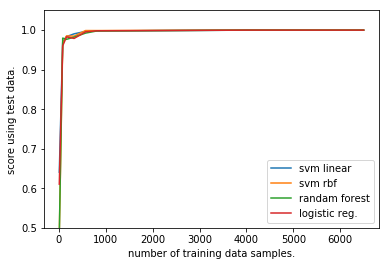

In [6]:
ax =svm_liner_scores_for_each_size.plot(x="X_train.shape[0]",y="test_score")
svm_rbf_scores_for_each_size.plot(x="X_train.shape[0]",y="test_score",ax=ax)
randam_fo_scores_for_each_size.plot(x="X_train.shape[0]",y="test_score",ax=ax)
logistic_r_scores_for_each_size.plot(x="X_train.shape[0]",y="test_score",ax=ax)
ax.legend(["svm linear", "svm rbf", "randam forest","logistic reg."])
plt.xlabel("number of training data samples.")
plt.ylabel("score using test data.")
plt.ylim(.5,1.05)

In [7]:
svm_liner_scores_for_each_size

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,1.0,1.000000,"(6499, 117)","(1625, 117)",6499
1,0,0.500,1.0,1.000000,"(4062, 117)","(4062, 117)",4062
2,0,0.900,1.0,0.997812,"(812, 117)","(7312, 117)",812
3,0,0.930,1.0,0.996824,"(568, 117)","(7556, 117)",568
4,0,0.960,1.0,0.990641,"(324, 117)","(7800, 117)",324
5,0,0.980,1.0,0.983672,"(162, 117)","(7962, 117)",162
6,0,0.990,1.0,0.969912,"(81, 117)","(8043, 117)",81
7,0,0.999,1.0,0.640710,"(8, 117)","(8116, 117)",8


In [8]:
svm_rbf_scores_for_each_size

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,1.000000,1.000000,"(6499, 117)","(1625, 117)",6499
1,0,0.500,1.000000,1.000000,"(4062, 117)","(4062, 117)",4062
2,0,0.900,1.000000,0.998906,"(812, 117)","(7312, 117)",812
3,0,0.930,1.000000,0.998941,"(568, 117)","(7556, 117)",568
4,0,0.960,0.996914,0.984744,"(324, 117)","(7800, 117)",324
5,0,0.980,1.000000,0.985431,"(162, 117)","(7962, 117)",162
6,0,0.990,1.000000,0.966057,"(81, 117)","(8043, 117)",81
7,0,0.999,0.750000,0.481764,"(8, 117)","(8116, 117)",8


In [9]:
randam_fo_scores_for_each_size

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,1.000000,1.000000,"(6499, 117)","(1625, 117)",6499
1,0,0.500,1.000000,1.000000,"(4062, 117)","(4062, 117)",4062
2,0,0.900,0.998768,0.997949,"(812, 117)","(7312, 117)",812
3,0,0.930,0.998239,0.992456,"(568, 117)","(7556, 117)",568
4,0,0.960,0.996914,0.982436,"(324, 117)","(7800, 117)",324
5,0,0.980,1.000000,0.976639,"(162, 117)","(7962, 117)",162
6,0,0.990,1.000000,0.979858,"(81, 117)","(8043, 117)",81
7,0,0.999,0.750000,0.481764,"(8, 117)","(8116, 117)",8


In [10]:
logistic_r_scores_for_each_size

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,1.000000,1.000000,"(6499, 117)","(1625, 117)",6499
1,0,0.500,1.000000,1.000000,"(4062, 117)","(4062, 117)",4062
2,0,0.900,1.000000,0.998359,"(812, 117)","(7312, 117)",812
3,0,0.930,1.000000,0.995633,"(568, 117)","(7556, 117)",568
4,0,0.960,0.996914,0.978974,"(324, 117)","(7800, 117)",324
5,0,0.980,1.000000,0.982919,"(162, 117)","(7962, 117)",162
6,0,0.990,1.000000,0.960338,"(81, 117)","(8043, 117)",81
7,0,0.999,1.000000,0.610399,"(8, 117)","(8116, 117)",8


# 説明変数を選ぶ。RandomForestでfittingし、importanceを利用する。

In [11]:
param_grid = {'max_depth':[5,7,10,12], 'n_estimators':[10,50,100,300]}
cv = GridSearchCV(RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, random_state=1234),param_grid=param_grid,cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
cv.fit(X_train, y_train)
cv.best_estimator_.score(X_test,y_test)

1.0

In [12]:
importances = pd.DataFrame( cv.best_estimator_.feature_importances_, index=X.columns, columns=["importance"])
print(importances.sort_values(by="importance", ascending=False).head(10))

# importanceが高いほう、低いほうを、nn個ずつ抽出する。
nn = 8 ## この値を変えて試す。
importance_top = importances.sort_values(by="importance", ascending=False).head(nn).index.tolist()
importance_btm = importances.sort_values(by="importance", ascending=False).tail(nn).index.tolist()

                            importance
odor_n                        0.186815
spore-print-color_h           0.096109
gill-size_n                   0.066876
bruises_t                     0.058053
gill-color_b                  0.053312
spore-print-color_n           0.047249
stalk-root_e                  0.039223
ring-type_p                   0.032305
odor_f                        0.025732
stalk-surface-below-ring_s    0.024403


## importanceが高い説明変数のみを使い、計算をする。

In [13]:
# train data, test dataを作る。
y_top = dfm_d.class_p.to_frame()
X_top = dfm_d.drop(["class_p","class_e"], axis=1)
X_top = X_top.loc[:,importance_top]

X_top.shape

(8124, 8)

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 解析用パラメータ保存データフレーム
svm_liner_scores_for_each_size_top  = pd.DataFrame(index=[],columns=tmp_columns)
svm_rbf_scores_for_each_size_top    = pd.DataFrame(index=[],columns=tmp_columns)
randam_fo_scores_for_each_size_top  = pd.DataFrame(index=[],columns=tmp_columns)
logistic_r_scores_for_each_size_top = pd.DataFrame(index=[],columns=tmp_columns)

for i in test_size_list:
    for j in range(test_split_num):
        ### Traindata,TestData
        X_train, X_test, y_train, y_test = train_test_split(X_top, y_top, test_size=i)
        
        ###
        ### svm linear start
        ###
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="linear")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm linear::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
        svm_liner_scores_for_each_size_top = svm_liner_scores_for_each_size_top.append(
            tmp_df, ignore_index=True)
       
        
        ####
        #### svm rbf start
        ####
        
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="rbf")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm rbf::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
       
        svm_rbf_scores_for_each_size_top = svm_rbf_scores_for_each_size_top.append(
            tmp_df, ignore_index=True)

        
        ####
        #### randam forest start
        ####        
        parameters = {'max_depth':[7,10,12], 'n_estimators':[10]}
        model = RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, random_state=1234)
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("randam forest::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        randam_fo_scores_for_each_size_top = randam_fo_scores_for_each_size_top.append(
            tmp_df, ignore_index=True)
        
        
        ####
        #### Logistic Regression
        ####        
        parameters = {'C':[1,5,10]}
        model = LogisticRegression()
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("logistic regression::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        logistic_r_scores_for_each_size_top = logistic_r_scores_for_each_size_top.append(
            tmp_df, ignore_index=True)
        


svm linear::: i,j,best C: 0.2   0   {'C': 1}
svm rbf::: i,j,best C: 0.2   0   {'C': 1}
randam forest::: i,j,best C: 0.2   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.2   0   {'C': 1}
svm linear::: i,j,best C: 0.5   0   {'C': 5}
svm rbf::: i,j,best C: 0.5   0   {'C': 1}
randam forest::: i,j,best C: 0.5   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.5   0   {'C': 1}
svm linear::: i,j,best C: 0.9   0   {'C': 1}
svm rbf::: i,j,best C: 0.9   0   {'C': 5}
randam forest::: i,j,best C: 0.9   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.9   0   {'C': 1}
svm linear::: i,j,best C: 0.93   0   {'C': 5}
svm rbf::: i,j,best C: 0.93   0   {'C': 10}
randam forest::: i,j,best C: 0.93   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.93   0   {'C': 5}
svm linear::: i,j,best C: 0.96   0   {'C': 5}
svm rbf::: i,j,best C: 0.96   0   {'C': 5}
randam forest::: i,j,best C: 0.96   0 

### importanceが高い説明変数を使った結果

(0.5, 1.05)

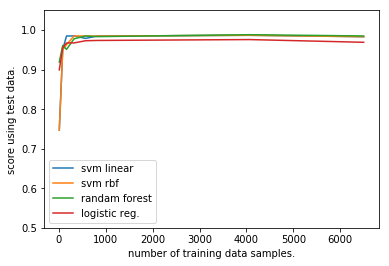

In [15]:
ax =svm_liner_scores_for_each_size_top.plot(x="X_train.shape[0]",y="test_score")
svm_rbf_scores_for_each_size_top.plot(x="X_train.shape[0]",y="test_score",ax=ax)
randam_fo_scores_for_each_size_top.plot(x="X_train.shape[0]",y="test_score",ax=ax)
logistic_r_scores_for_each_size_top.plot(x="X_train.shape[0]",y="test_score",ax=ax)
ax.legend(["svm linear", "svm rbf", "randam forest","logistic reg."])
plt.xlabel("number of training data samples.")
plt.ylabel("score using test data.")
plt.ylim(.5,1.05)


In [16]:
svm_liner_scores_for_each_size_top 

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,0.985690,0.983385,"(6499, 8)","(1625, 8)",6499
1,0,0.500,0.983506,0.986952,"(4062, 8)","(4062, 8)",4062
2,0,0.900,0.987685,0.984956,"(812, 8)","(7312, 8)",812
3,0,0.930,0.982394,0.979089,"(568, 8)","(7556, 8)",568
4,0,0.960,0.984568,0.985256,"(324, 8)","(7800, 8)",324
5,0,0.980,0.987654,0.985180,"(162, 8)","(7962, 8)",162
6,0,0.990,0.987654,0.950889,"(81, 8)","(8043, 8)",81
7,0,0.999,1.000000,0.747166,"(8, 8)","(8116, 8)",8


In [17]:
svm_rbf_scores_for_each_size_top

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,0.985690,0.983385,"(6499, 8)","(1625, 8)",6499
1,0,0.500,0.983506,0.986952,"(4062, 8)","(4062, 8)",4062
2,0,0.900,0.987685,0.984956,"(812, 8)","(7312, 8)",812
3,0,0.930,0.985915,0.985177,"(568, 8)","(7556, 8)",568
4,0,0.960,0.984568,0.985256,"(324, 8)","(7800, 8)",324
5,0,0.980,0.962963,0.963075,"(162, 8)","(7962, 8)",162
6,0,0.990,0.987654,0.950889,"(81, 8)","(8043, 8)",81
7,0,0.999,1.000000,0.747166,"(8, 8)","(8116, 8)",8


In [18]:
randam_fo_scores_for_each_size_top

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,0.986459,0.985231,"(6499, 8)","(1625, 8)",6499
1,0,0.500,0.983998,0.988429,"(4062, 8)","(4062, 8)",4062
2,0,0.900,0.990148,0.983589,"(812, 8)","(7312, 8)",812
3,0,0.930,0.985915,0.985177,"(568, 8)","(7556, 8)",568
4,0,0.960,0.984568,0.978077,"(324, 8)","(7800, 8)",324
5,0,0.980,0.950617,0.951269,"(162, 8)","(7962, 8)",162
6,0,0.990,0.987654,0.961333,"(81, 8)","(8043, 8)",81
7,0,0.999,1.000000,0.919172,"(8, 8)","(8116, 8)",8


In [19]:
logistic_r_scores_for_each_size_top

,test_spulit_num,test_size,train_score,test_score,X_train.shape,X_test.shape,X_train.shape[0]
0,0,0.200,0.974458,0.969231,"(6499, 8)","(1625, 8)",6499
1,0,0.500,0.970704,0.976120,"(4062, 8)","(4062, 8)",4062
2,0,0.900,0.969212,0.973879,"(812, 8)","(7312, 8)",812
3,0,0.930,0.977113,0.973134,"(568, 8)","(7556, 8)",568
4,0,0.960,0.962963,0.967692,"(324, 8)","(7800, 8)",324
5,0,0.980,0.969136,0.967470,"(162, 8)","(7962, 8)",162
6,0,0.990,0.987654,0.955365,"(81, 8)","(8043, 8)",81
7,0,0.999,1.000000,0.899458,"(8, 8)","(8116, 8)",8


## importanceが低い説明変数のみを使って、計算をする

In [20]:
# train data, test dataを作る。
y_btm = dfm_d.class_p.to_frame()
X_btm = dfm_d.drop(["class_p","class_e"], axis=1)
X_btm = X_btm.loc[:,importance_btm]

X_btm.shape


(8124, 8)

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
# 初期化
svm_liner_scores_for_each_size_btm  = pd.DataFrame(index=[],columns=tmp_columns)
svm_rbf_scores_for_each_size_btm    = pd.DataFrame(index=[],columns=tmp_columns)
randam_fo_scores_for_each_size_btm  = pd.DataFrame(index=[],columns=tmp_columns)
logistic_r_scores_for_each_size_btm = pd.DataFrame(index=[],columns=tmp_columns)

for i in test_size_list:
    for j in range(test_split_num):
        ### Traindata,TestData
        X_train, X_test, y_train, y_test = train_test_split(X_btm, y_btm, test_size=i)
        
        ###
        ### svm linear start
        ###
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="linear")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm linear::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
        svm_liner_scores_for_each_size_btm = svm_liner_scores_for_each_size_btm.append(
            tmp_df, ignore_index=True)
       
        
        ####
        #### svm rbf start
        ####
        
        parameters = {'C':[1, 5, 10]}
        model = SVC(kernel="rbf")
        clf = GridSearchCV(model, parameters, cv=3)
        clf.fit(X_train, y_train)
        
        print("svm rbf::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)
       
        svm_rbf_scores_for_each_size_btm = svm_rbf_scores_for_each_size_btm.append(
            tmp_df, ignore_index=True)

        
        ####
        #### randam forest start
        ####        
        parameters = {'max_depth':[7,10,12], 'n_estimators':[10]}
        model = RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, random_state=1234)
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("randam forest::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        randam_fo_scores_for_each_size_btm = randam_fo_scores_for_each_size_btm.append(
            tmp_df, ignore_index=True)
        
        
        ####
        #### Logistic Regression
        ####        
        parameters = {'C':[1,5,10]}
        model = LogisticRegression()
        clf = GridSearchCV(model, parameters ,cv=3)
        clf.fit(X_train, y_train)
        
        print("logistic regression::: i,j,best C:", i ," " , j ," ",clf.best_params_)
        train_score = clf.best_estimator_.score(X_train, y_train)
        test_score  = clf.best_estimator_.score(X_test , y_test)

        tmp_df = pd.Series([j ,i ,train_score,test_score,X_train.shape,X_test.shape, X_train.shape[0]] ,index=tmp_columns)       
        logistic_r_scores_for_each_size_btm = logistic_r_scores_for_each_size_btm.append(
            tmp_df, ignore_index=True)
        


svm linear::: i,j,best C: 0.2   0   {'C': 5}
svm rbf::: i,j,best C: 0.2   0   {'C': 5}
randam forest::: i,j,best C: 0.2   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.2   0   {'C': 10}
svm linear::: i,j,best C: 0.5   0   {'C': 5}
svm rbf::: i,j,best C: 0.5   0   {'C': 5}
randam forest::: i,j,best C: 0.5   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.5   0   {'C': 10}
svm linear::: i,j,best C: 0.9   0   {'C': 1}
svm rbf::: i,j,best C: 0.9   0   {'C': 1}
randam forest::: i,j,best C: 0.9   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.9   0   {'C': 1}
svm linear::: i,j,best C: 0.93   0   {'C': 1}
svm rbf::: i,j,best C: 0.93   0   {'C': 1}
randam forest::: i,j,best C: 0.93   0   {'max_depth': 7, 'n_estimators': 10}
logistic regression::: i,j,best C: 0.93   0   {'C': 1}
svm linear::: i,j,best C: 0.96   0   {'C': 1}
svm rbf::: i,j,best C: 0.96   0   {'C': 1}
randam forest::: i,j,best C: 0.96   0

(0.5, 1.05)

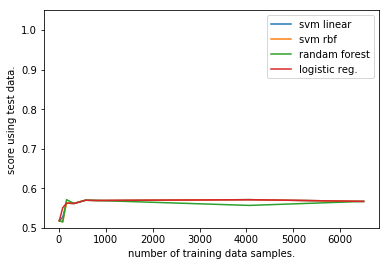

In [22]:
ax =svm_liner_scores_for_each_size_btm.plot(x="X_train.shape[0]",y="test_score")
svm_rbf_scores_for_each_size_btm.plot(x="X_train.shape[0]",y="test_score",ax=ax)
randam_fo_scores_for_each_size_btm.plot(x="X_train.shape[0]",y="test_score",ax=ax)
logistic_r_scores_for_each_size_btm.plot(x="X_train.shape[0]",y="test_score",ax=ax)
ax.legend(["svm linear", "svm rbf", "randam forest","logistic reg."])
plt.xlabel("number of training data samples.")
plt.ylabel("score using test data.")
plt.ylim(.5,1.05)
## 説明変数を下から選ぶとスコアは0.6程度まで落ちる。二択問題なので下限は0.5。